# PySINDy Package Feature Overview

This notebook provides a simple overview of the basic functionality of the PySINDy software package. In addition to demonstrating the basic usage for fitting a SINDy model, we demonstrate several means of customizing the SINDy fitting procedure. These include different forms of input data, different optimization methods, different differentiation methods, and custom feature libraries.

In [1]:
import warnings

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint

import pysindy as ps

%matplotlib inline
warnings.filterwarnings('ignore')

# Basic usage

In [2]:
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

## Train the model

In [3]:
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)

In [4]:
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Assess results on a test trajectory

In [5]:
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)
x_test_sim = model.simulate(x0_test, t_test)

x_dot_test_computed = model.differentiate(x_test, t=dt)
x_dot_test_predicted = model.predict(x_test)

print('Model score: %f' % model.score(x_test, t=dt))

Model score: 1.000000


## Predict derivatives with learned model

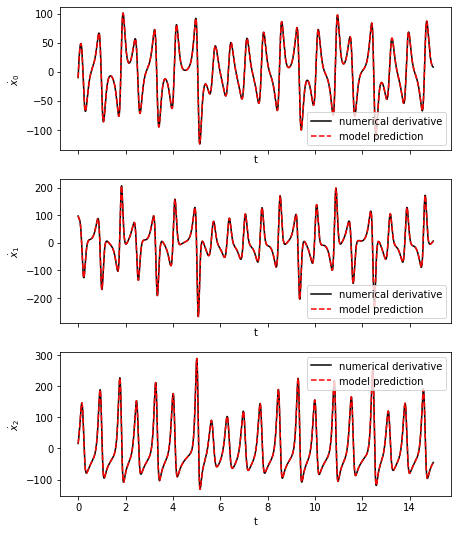

In [6]:
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

## Simulate forward in time

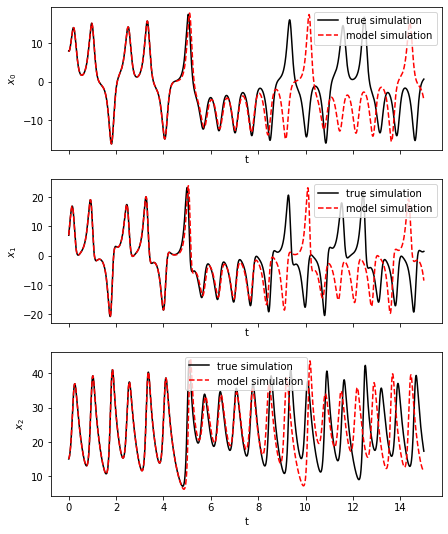

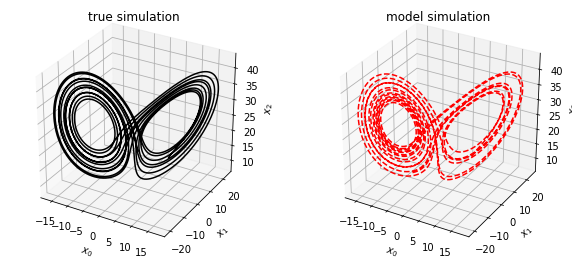

In [7]:
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

# Different forms of input data

## Single trajectory, pass in collection times

In [8]:
model = ps.SINDy()
model.fit(x_train, t=t_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Single trajectory, pass in pre-computed derivatives

In [9]:
x_dot_true = np.zeros(x_train.shape)
for i in range(t_train.size):
    x_dot_true[i] = lorenz(x_train[i], t_train[i])
    
model = ps.SINDy()
model.fit(x_train, t=t_train, x_dot=x_dot_true)
model.print()

x0' = -10.000 x0 + 10.000 x1
x1' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
x2' = -2.667 x2 + 1.000 x0 x1


## Multiple trajectories

In [10]:
n_trajectories = 20
x0s = np.array([36, 48, 41]) * (
    np.random.rand(n_trajectories, 3) - 0.5
) + np.array([0, 0, 25])
x_train_multi = []
for i in range(n_trajectories):
    x_train_multi.append(odeint(lorenz, x0s[i], t_train))

model = ps.SINDy()
model.fit(x_train_multi, t=dt, multiple_trajectories=True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.993 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Multiple trajectories, different lengths of time

In [11]:
n_trajectories = 20
x0s = np.array([36, 48, 41]) * (
    np.random.rand(n_trajectories, 3) - 0.5
) + np.array([0, 0, 25])
x_train_multi = []
t_train_multi = []
for i in range(n_trajectories):
    n_samples = np.random.randint(500, 1500)
    t = np.arange(0, n_samples * dt, dt)
    x_train_multi.append(odeint(lorenz, x0s[i], t))
    t_train_multi.append(t)

model = ps.SINDy()
model.fit(x_train_multi, t=t_train_multi, multiple_trajectories=True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Discrete time dynamical system (map)

In [12]:
def f(x):
    return 3.6 * x * (1 - x)


n_steps = 1000
eps = 0.001
x_train_map = np.zeros((n_steps))
x_train_map[0] = 0.5
for i in range(1, n_steps):
    x_train_map[i] = f(x_train_map[i - 1]) + eps * np.random.randn()

model = ps.SINDy(discrete_time=True)
model.fit(x_train_map)
model.print()

x0[k+1] = 3.599 x0[k] + -3.599 x0[k]^2


# Optimization options

## STLSQ - change parameters

In [13]:
stlsq_optimizer = ps.STLSQ(threshold=.01, alpha=.5)

model = ps.SINDy(optimizer=stlsq_optimizer)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## SR3

In [14]:
sr3_optimizer = ps.SR3(threshold=0.1, nu=1)

model = ps.SINDy(optimizer=sr3_optimizer)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## LASSO

In [15]:
lasso_optimizer = ps.LASSO(alpha=100)

model = ps.SINDy(optimizer=lasso_optimizer)
model.fit(x_train, t=dt)
model.print()

x0' = -0.310 x0 x2 + 0.342 x1 x2 + -0.003 x2^2
x1' = 15.915 x1 + 0.006 x0 x1 + -0.219 x0 x2 + -0.473 x1 x2 + 0.005 x2^2
x2' = 0.261 x0^2 + 0.832 x0 x1 + -0.003 x1 x2 + -0.074 x2^2


# Differentiation options

## Pass in pre-computed derivatives

In [16]:
x_dot_precomputed = ps.FiniteDifference()._differentiate(x_train, t_train)
    
model = ps.SINDy()
model.fit(x_train, t=t_train, x_dot=x_dot_precomputed)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Drop end points from finite difference computation

In [17]:
fd_dropEndpoints = ps.FiniteDifference(drop_endpoints=True)
    
model = ps.SINDy(differentiation_method=fd_dropEndpoints)
model.fit(x_train, t=t_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Smoothed finite difference

In [18]:
smoothedFD = ps.SmoothedFiniteDifference()
    
model = ps.SINDy(differentiation_method=smoothedFD)
model.fit(x_train, t=t_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


# Feature libraries

## Custom feature names

In [19]:
feature_names = ['x', 'y', 'z']
model = ps.SINDy(feature_names=feature_names)
model.fit(x_train, t=dt)
model.print()

x' = -9.999 x + 9.999 y
y' = 27.992 x + -0.998 y + -1.000 x z
z' = -2.666 z + 1.000 x y


## Custom left hand side when printing the model

In [20]:
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print(lhs=['dx0/dt', 'dx1/dt', 'dx2/dt'])

dx0/dt = -9.999 x0 + 9.999 x1
dx1/dt = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
dx2/dt = -2.666 x2 + 1.000 x0 x1


## Customize polynomial library

In [21]:
poly_library = ps.PolynomialLibrary(include_interaction=False)

model = ps.SINDy(feature_library=poly_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = -13.015 x0 + 9.230 x1 + 9.452 x2 + 0.598 x0^2 + -0.289 x1^2 + -0.247 x2^2
x2' = 0.624 x0 + -0.558 x1 + 2.866 x2 + 1.001 x0^2 + 0.260 x1^2 + -0.176 x2^2


## Fourier library

In [22]:
fourier_library = ps.FourierLibrary(n_frequencies=3)

model = ps.SINDy(feature_library=fourier_library)
model.fit(x_train, t=dt)
model.print()

x0' = 0.622 sin(1 x0) + 0.977 cos(1 x0) + 5.925 cos(1 x1) + -2.705 sin(1 x2) + 3.998 cos(1 x2) + -0.346 cos(2 x0) + -0.700 sin(2 x1) + -1.124 cos(2 x1) + 0.470 sin(2 x2) + 0.237 cos(2 x2) + 0.519 sin(3 x0) + 0.260 cos(3 x0) + 3.066 sin(3 x1) + 0.786 cos(3 x1) + 2.399 sin(3 x2) + -1.904 cos(3 x2)
x1' = -2.622 sin(1 x0) + -4.103 cos(1 x0) + -0.439 sin(1 x1) + 0.427 cos(1 x1) + -4.714 sin(1 x2) + 7.943 cos(1 x2) + -1.053 sin(2 x0) + -5.593 cos(2 x0) + -1.198 sin(2 x1) + -1.145 cos(2 x1) + 3.318 sin(2 x2) + 1.138 cos(2 x2) + 1.973 sin(3 x0) + 4.860 cos(3 x0) + -0.496 sin(3 x1) + 0.639 cos(3 x1) + 4.257 sin(3 x2) + -3.074 cos(3 x2)
x2' = 5.267 sin(1 x0) + 4.750 cos(1 x0) + 5.567 sin(1 x1) + -3.250 cos(1 x1) + -1.079 sin(1 x2) + 0.333 cos(1 x2) + 2.728 sin(2 x0) + 2.145 cos(2 x0) + -4.638 sin(2 x1) + -14.020 cos(2 x1) + -0.687 sin(2 x2) + 2.660 sin(3 x0) + -0.289 cos(3 x0) + 5.419 sin(3 x1) + -8.274 cos(3 x1) + 0.718 sin(3 x2) + -0.262 cos(3 x2)


## Fully custom library

In [23]:
library_functions = [
    lambda x : np.exp(x),
    lambda x : 1./x,
    lambda x : x,
    lambda x,y : np.sin(x+y)
]
library_function_names = [
    lambda x : 'exp(' + x + ')',
    lambda x : '1/' + x,
    lambda x : x,
    lambda x,y : 'sin(' + x + ',' + y + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 1.357 1/x0 + -670.751 1/x2 + -12.336 x0 + 8.982 x1 + -1.461 x2 + 0.983 sin(x0,x1) + 1.094 sin(x0,x2) + -0.206 sin(x1,x2)
x2' = 1.144 1/x0 + 46.944 1/x2 + 0.148 x0 + 0.177 x1 + 3.611 sin(x0,x1) + -3.351 sin(x0,x2) + -2.983 sin(x1,x2)


## Fully custom library, default function names

In [24]:
library_functions = [
    lambda x : np.exp(x),
    lambda x : 1./x,
    lambda x : x,
    lambda x,y : np.sin(x+y)
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 f2(x0) + 9.999 f2(x1)
x1' = 1.357 f1(x0) + -670.751 f1(x2) + -12.336 f2(x0) + 8.982 f2(x1) + -1.461 f2(x2) + 0.983 f3(x0,x1) + 1.094 f3(x0,x2) + -0.206 f3(x1,x2)
x2' = 1.144 f1(x0) + 46.944 f1(x2) + 0.148 f2(x0) + 0.177 f2(x1) + 3.611 f3(x0,x1) + -3.351 f3(x0,x2) + -2.983 f3(x1,x2)


## Identity library

In [25]:
identity_library = ps.IdentityLibrary()

model = ps.SINDy(feature_library=identity_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = -12.443 x0 + 9.307 x1 + 0.234 x2
x2' = 0.215 x0 + 0.115 x1
